<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix



#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time

In [3]:
%%capture
!wget https://www.dropbox.com/s/ja56cvf3x4mkf1t/modelnet10_voxelized_32.npz

In [4]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          tmp = np.load("modelnet10_voxelized_32.npz")
          self.data = tmp["X_train"]
          self.label = tmp["Y_train"]
          del tmp
      else:
          tmp = np.load("modelnet10_voxelized_32.npz")
          self.data = tmp["X_test"]
          self.label = tmp["Y_test"]
          del tmp
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        #flip x
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=0)
        
        #flip y
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        
        voxels = rotate(voxels, axes=(0, 1), angle=angle, cval=0.0, reshape=False)
        
        
        return voxels.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [5]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x


In [7]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

def blue(x): return '\033[94m' + x + '\033[0m'

train_ds = VoxelDataset(train=True)
test_ds = VoxelDataset(train=False)
train_dataloader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=32)

pred_conf, y_conf = [], []                                                           

train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []
train_accuracy = Accuracy(task='multiclass', num_classes=10)
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

model = VoxNet()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = F.cross_entropy
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs = 100
best_val = np.inf

num_batch = len(train_ds) / 32
print(num_batch)

total_time = time.time()

for epoch in range(epochs):
    t = time.time()

    temp_correct = 0
    temp_testset = 0
    temp_correct_test = 0
    temp_testset_test = 0
    train_loss = []                                                         #track training loss
    test_loss = []
    model.train()
    iterator = tqdm(enumerate(train_dataloader, 0))
    for i, data in iterator:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        pred = model(inputs)  # torch.Size([256, 10])
        loss = F.cross_entropy(pred,labels)
        train_loss.append(loss.cpu().data)
        acc = train_accuracy(torch.argmax(pred, 1).cpu(), labels.cpu()) 

        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(labels.data).cpu().sum()
        
        temp_correct += correct.item()
        temp_testset += inputs.size()[0]
        
    with torch.no_grad():
      model.eval()
      for j, sample in tqdm(enumerate(test_dataloader, 0)):    
          inputs_test, labels_test = sample[0], sample[1]
          inputs_test = inputs_test.to(device)
          labels_test = labels_test.to(device)
          inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
          
          pred_test = model(inputs_test)
          loss_test = F.nll_loss(pred_test, labels_test)
          test_loss.append(loss.cpu().data)
          valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
          pred_choice_test = pred_test.data.max(1)[1]
          correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
          pred_conf.append(torch.argmax(pred_test, 1))
          y_conf.append(labels_test)
          
          temp_correct_test += correct_test.item()
          temp_testset_test += inputs_test.size()[0]

    #compute confusion matrix
    a = torch.cat(pred_conf).cpu()
    b = torch.cat(y_conf).cpu()
    confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
    conf_matrix = confmat(a, b)
    conf_matrix = torch.round(conf_matrix, decimals=2)

    # total accuracy over all batches
    total_train_accuracy = train_accuracy.compute()
    total_valid_accuracy = valid_accuracy.compute()
    train_accuracy.reset()
    valid_accuracy.reset()
           
    #track loss and acc for plotting
    train_loss_history.append(torch.mean(torch.tensor(train_loss)))
    valid_loss_history.append(torch.mean(torch.tensor(test_loss)))
    train_acc_history.append(total_train_accuracy)
    valid_acc_history.append(total_valid_accuracy)
    history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
               "test_loss": torch.tensor(valid_loss_history), "test_acc": torch.tensor(valid_acc_history)}

    elapsed_time_epoch = time.time() - t
    tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, epochs)
    tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
    tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
    tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
    print(tmp0, tmp1, tmp2, tmp3, sep="\n")           
    
    #print("epoch %d: train accuracy %f" % (epoch, temp_correct / float(temp_testset)))
    #print("epoch %d: test accuracy %f" % (epoch+1, temp_correct_test / float(temp_testset_test)))

    


total_correct = 0
total_testset = 0

model.eval()
for i, data in tqdm(enumerate(test_dataloader, 0)):
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.float()  # 转float, torch.Size([256, 1, 32, 32, 32])

    
    pred = model(inputs)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(labels.data).cpu().sum()
    total_correct += correct.item()
    total_testset += inputs.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))



124.71875


Train loss: 1.4319716691970825: : 124it [01:16,  1.62it/s]
29it [00:08,  3.42it/s]


epoch:  1 /100
time: 84.93 seconds
train-loss: 1.86, train-acc: 37.00%
valid-loss: 1.43, valid-acc: 53.74%



Train loss: 0.9921849966049194: : 124it [01:13,  1.70it/s]
29it [00:08,  3.45it/s]


epoch:  2 /100
time: 81.56 seconds
train-loss: 1.12, train-acc: 62.73%
valid-loss: 0.99, valid-acc: 68.17%



Train loss: 0.8426615595817566: : 124it [01:13,  1.68it/s]
29it [00:08,  3.47it/s]


epoch:  3 /100
time: 82.27 seconds
train-loss: 0.92, train-acc: 69.58%
valid-loss: 0.84, valid-acc: 70.93%



Train loss: 0.8063934445381165: : 124it [01:12,  1.72it/s]
29it [00:08,  3.44it/s]


epoch:  4 /100
time: 80.64 seconds
train-loss: 0.84, train-acc: 73.39%
valid-loss: 0.81, valid-acc: 72.80%



Train loss: 0.5583372712135315: : 124it [01:14,  1.67it/s]
29it [00:09,  2.95it/s]


epoch:  5 /100
time: 84.24 seconds
train-loss: 0.75, train-acc: 75.35%
valid-loss: 0.56, valid-acc: 70.70%



Train loss: 0.3912012577056885: : 124it [01:12,  1.71it/s]
29it [00:08,  3.44it/s]


epoch:  6 /100
time: 80.88 seconds
train-loss: 0.71, train-acc: 76.21%
valid-loss: 0.39, valid-acc: 75.88%



Train loss: 0.6950502395629883: : 124it [01:12,  1.71it/s]
29it [00:09,  3.20it/s]


epoch:  7 /100
time: 81.62 seconds
train-loss: 0.66, train-acc: 79.03%
valid-loss: 0.70, valid-acc: 76.32%



Train loss: 0.6846826672554016: : 124it [01:15,  1.65it/s]
29it [00:08,  3.44it/s]


epoch:  8 /100
time: 83.46 seconds
train-loss: 0.62, train-acc: 80.29%
valid-loss: 0.68, valid-acc: 78.96%



Train loss: 0.3451903760433197: : 124it [01:12,  1.71it/s]
29it [00:08,  3.50it/s]


epoch:  9 /100
time: 80.93 seconds
train-loss: 0.59, train-acc: 80.72%
valid-loss: 0.35, valid-acc: 80.07%



Train loss: 0.3070564568042755: : 124it [01:13,  1.69it/s]
29it [00:08,  3.48it/s]


epoch: 10 /100
time: 81.74 seconds
train-loss: 0.56, train-acc: 81.78%
valid-loss: 0.31, valid-acc: 79.96%



Train loss: 0.5260335206985474: : 124it [01:13,  1.70it/s]
29it [00:08,  3.48it/s]


epoch: 11 /100
time: 81.44 seconds
train-loss: 0.55, train-acc: 82.46%
valid-loss: 0.53, valid-acc: 80.73%



Train loss: 0.30422064661979675: : 124it [01:13,  1.68it/s]
29it [00:08,  3.48it/s]


epoch: 12 /100
time: 82.12 seconds
train-loss: 0.51, train-acc: 83.04%
valid-loss: 0.30, valid-acc: 81.39%



Train loss: 1.069761037826538: : 124it [01:13,  1.69it/s]
29it [00:08,  3.49it/s]


epoch: 13 /100
time: 81.89 seconds
train-loss: 0.49, train-acc: 84.20%
valid-loss: 1.07, valid-acc: 81.17%



Train loss: 0.9722479581832886: : 124it [01:12,  1.72it/s]
29it [00:08,  3.49it/s]


epoch: 14 /100
time: 80.47 seconds
train-loss: 0.49, train-acc: 84.80%
valid-loss: 0.97, valid-acc: 82.27%



Train loss: 0.6078237891197205: : 124it [01:13,  1.69it/s]
29it [00:08,  3.47it/s]


epoch: 15 /100
time: 81.82 seconds
train-loss: 0.46, train-acc: 85.33%
valid-loss: 0.61, valid-acc: 83.15%



Train loss: 0.25165030360221863: : 124it [01:12,  1.72it/s]
29it [00:08,  3.49it/s]


epoch: 16 /100
time: 80.56 seconds
train-loss: 0.45, train-acc: 85.71%
valid-loss: 0.25, valid-acc: 79.74%



Train loss: 0.3786979019641876: : 124it [01:12,  1.72it/s]
29it [00:08,  3.47it/s]


epoch: 17 /100
time: 80.46 seconds
train-loss: 0.44, train-acc: 86.39%
valid-loss: 0.38, valid-acc: 83.15%



Train loss: 0.2901946008205414: : 124it [01:13,  1.69it/s]
29it [00:08,  3.48it/s]


epoch: 18 /100
time: 81.87 seconds
train-loss: 0.42, train-acc: 86.44%
valid-loss: 0.29, valid-acc: 82.60%



Train loss: 0.45699700713157654: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 19 /100
time: 80.98 seconds
train-loss: 0.41, train-acc: 87.35%
valid-loss: 0.46, valid-acc: 85.13%



Train loss: 0.3806418180465698: : 124it [01:13,  1.68it/s]
29it [00:08,  3.46it/s]


epoch: 20 /100
time: 82.12 seconds
train-loss: 0.41, train-acc: 86.74%
valid-loss: 0.38, valid-acc: 84.25%



Train loss: 0.39263594150543213: : 124it [01:12,  1.70it/s]
29it [00:08,  3.43it/s]


epoch: 21 /100
time: 81.25 seconds
train-loss: 0.38, train-acc: 87.55%
valid-loss: 0.39, valid-acc: 83.70%



Train loss: 0.18318310379981995: : 124it [01:12,  1.71it/s]
29it [00:09,  3.03it/s]


epoch: 22 /100
time: 81.96 seconds
train-loss: 0.38, train-acc: 87.78%
valid-loss: 0.18, valid-acc: 85.24%



Train loss: 0.35353922843933105: : 124it [01:12,  1.70it/s]
29it [00:08,  3.45it/s]


epoch: 23 /100
time: 81.43 seconds
train-loss: 0.38, train-acc: 87.85%
valid-loss: 0.35, valid-acc: 85.68%



Train loss: 0.27667221426963806: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 24 /100
time: 80.79 seconds
train-loss: 0.35, train-acc: 88.43%
valid-loss: 0.28, valid-acc: 85.79%



Train loss: 0.26920247077941895: : 124it [01:13,  1.69it/s]
29it [00:08,  3.48it/s]


epoch: 25 /100
time: 81.93 seconds
train-loss: 0.35, train-acc: 89.21%
valid-loss: 0.27, valid-acc: 85.35%



Train loss: 0.24273236095905304: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch: 26 /100
time: 80.98 seconds
train-loss: 0.35, train-acc: 89.01%
valid-loss: 0.24, valid-acc: 85.46%



Train loss: 0.2643595039844513: : 124it [01:13,  1.69it/s]
29it [00:08,  3.29it/s]


epoch: 27 /100
time: 82.11 seconds
train-loss: 0.33, train-acc: 89.06%
valid-loss: 0.26, valid-acc: 84.58%



Train loss: 0.2756873667240143: : 124it [01:12,  1.71it/s]
29it [00:08,  3.49it/s]


epoch: 28 /100
time: 80.67 seconds
train-loss: 0.32, train-acc: 89.39%
valid-loss: 0.28, valid-acc: 85.68%



Train loss: 0.21631267666816711: : 124it [01:12,  1.72it/s]
29it [00:08,  3.48it/s]


epoch: 29 /100
time: 80.38 seconds
train-loss: 0.31, train-acc: 89.82%
valid-loss: 0.22, valid-acc: 85.35%



Train loss: 0.1311691701412201: : 124it [01:13,  1.69it/s]
29it [00:08,  3.47it/s]


epoch: 30 /100
time: 81.64 seconds
train-loss: 0.31, train-acc: 89.42%
valid-loss: 0.13, valid-acc: 85.13%



Train loss: 0.4367924928665161: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 31 /100
time: 80.81 seconds
train-loss: 0.30, train-acc: 89.99%
valid-loss: 0.44, valid-acc: 85.90%



Train loss: 0.2680246829986572: : 124it [01:13,  1.69it/s]
29it [00:08,  3.50it/s]


epoch: 32 /100
time: 81.73 seconds
train-loss: 0.30, train-acc: 90.17%
valid-loss: 0.27, valid-acc: 85.79%



Train loss: 0.0982685461640358: : 124it [01:11,  1.72it/s]
29it [00:08,  3.51it/s]


epoch: 33 /100
time: 80.22 seconds
train-loss: 0.29, train-acc: 90.15%
valid-loss: 0.10, valid-acc: 86.78%



Train loss: 0.39428678154945374: : 124it [01:12,  1.72it/s]
29it [00:08,  3.49it/s]


epoch: 34 /100
time: 80.35 seconds
train-loss: 0.29, train-acc: 90.78%
valid-loss: 0.39, valid-acc: 86.01%



Train loss: 0.2416045218706131: : 124it [01:13,  1.69it/s]
29it [00:08,  3.51it/s]


epoch: 35 /100
time: 81.55 seconds
train-loss: 0.28, train-acc: 90.83%
valid-loss: 0.24, valid-acc: 86.12%



Train loss: 0.17767207324504852: : 124it [01:12,  1.72it/s]
29it [00:08,  3.49it/s]


epoch: 36 /100
time: 80.49 seconds
train-loss: 0.29, train-acc: 90.27%
valid-loss: 0.18, valid-acc: 87.33%



Train loss: 0.3716440498828888: : 124it [01:13,  1.69it/s]
29it [00:08,  3.50it/s]


epoch: 37 /100
time: 81.88 seconds
train-loss: 0.27, train-acc: 90.65%
valid-loss: 0.37, valid-acc: 85.90%



Train loss: 0.2616337835788727: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 38 /100
time: 80.79 seconds
train-loss: 0.26, train-acc: 91.66%
valid-loss: 0.26, valid-acc: 86.12%



Train loss: 0.24884003400802612: : 124it [01:12,  1.71it/s]
29it [00:08,  3.48it/s]


epoch: 39 /100
time: 81.01 seconds
train-loss: 0.25, train-acc: 91.63%
valid-loss: 0.25, valid-acc: 85.46%



Train loss: 0.34792378544807434: : 124it [01:13,  1.69it/s]
29it [00:08,  3.48it/s]


epoch: 40 /100
time: 81.74 seconds
train-loss: 0.25, train-acc: 91.23%
valid-loss: 0.35, valid-acc: 87.22%



Train loss: 0.12344672530889511: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch: 41 /100
time: 80.89 seconds
train-loss: 0.24, train-acc: 91.41%
valid-loss: 0.12, valid-acc: 87.11%



Train loss: 0.18730434775352478: : 124it [01:13,  1.68it/s]
29it [00:08,  3.43it/s]


epoch: 42 /100
time: 82.19 seconds
train-loss: 0.25, train-acc: 91.99%
valid-loss: 0.19, valid-acc: 87.44%



Train loss: 0.2657533586025238: : 124it [01:12,  1.72it/s]
29it [00:08,  3.50it/s]


epoch: 43 /100
time: 80.35 seconds
train-loss: 0.24, train-acc: 91.71%
valid-loss: 0.27, valid-acc: 86.89%



Train loss: 0.41365090012550354: : 124it [01:12,  1.72it/s]
29it [00:08,  3.51it/s]


epoch: 44 /100
time: 80.41 seconds
train-loss: 0.23, train-acc: 91.99%
valid-loss: 0.41, valid-acc: 86.78%



Train loss: 0.5021126866340637: : 124it [01:13,  1.69it/s]
29it [00:08,  3.49it/s]


epoch: 45 /100
time: 81.67 seconds
train-loss: 0.23, train-acc: 92.34%
valid-loss: 0.50, valid-acc: 85.79%



Train loss: 0.2619549334049225: : 124it [01:11,  1.72it/s]
29it [00:08,  3.50it/s]


epoch: 46 /100
time: 80.25 seconds
train-loss: 0.23, train-acc: 92.59%
valid-loss: 0.26, valid-acc: 86.67%



Train loss: 0.1390930563211441: : 124it [01:13,  1.69it/s]
29it [00:08,  3.51it/s]


epoch: 47 /100
time: 81.52 seconds
train-loss: 0.24, train-acc: 91.73%
valid-loss: 0.14, valid-acc: 86.45%



Train loss: 0.2420196384191513: : 124it [01:11,  1.73it/s]
29it [00:08,  3.50it/s]


epoch: 48 /100
time: 80.17 seconds
train-loss: 0.23, train-acc: 92.52%
valid-loss: 0.24, valid-acc: 85.13%



Train loss: 0.27381831407546997: : 124it [01:11,  1.73it/s]
29it [00:08,  3.50it/s]


epoch: 49 /100
time: 80.19 seconds
train-loss: 0.22, train-acc: 92.36%
valid-loss: 0.27, valid-acc: 85.35%



Train loss: 0.2445027381181717: : 124it [01:13,  1.69it/s]
29it [00:08,  3.49it/s]


epoch: 50 /100
time: 81.56 seconds
train-loss: 0.22, train-acc: 92.39%
valid-loss: 0.24, valid-acc: 86.67%



Train loss: 0.2467789649963379: : 124it [01:11,  1.72it/s]
29it [00:08,  3.50it/s]


epoch: 51 /100
time: 80.32 seconds
train-loss: 0.23, train-acc: 92.16%
valid-loss: 0.25, valid-acc: 87.22%



Train loss: 0.18635563552379608: : 124it [01:13,  1.69it/s]
29it [00:08,  3.46it/s]


epoch: 52 /100
time: 81.58 seconds
train-loss: 0.21, train-acc: 92.52%
valid-loss: 0.19, valid-acc: 87.33%



Train loss: 0.25938835740089417: : 124it [01:12,  1.71it/s]
29it [00:08,  3.48it/s]


epoch: 53 /100
time: 80.77 seconds
train-loss: 0.21, train-acc: 92.92%
valid-loss: 0.26, valid-acc: 87.22%



Train loss: 0.10210162401199341: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 54 /100
time: 80.96 seconds
train-loss: 0.20, train-acc: 93.50%
valid-loss: 0.10, valid-acc: 86.67%



Train loss: 0.08385380357503891: : 124it [01:13,  1.68it/s]
29it [00:08,  3.47it/s]


epoch: 55 /100
time: 81.97 seconds
train-loss: 0.20, train-acc: 92.82%
valid-loss: 0.08, valid-acc: 87.00%



Train loss: 0.13076530396938324: : 124it [01:12,  1.72it/s]
29it [00:08,  3.51it/s]


epoch: 56 /100
time: 80.47 seconds
train-loss: 0.19, train-acc: 93.40%
valid-loss: 0.13, valid-acc: 85.46%



Train loss: 0.11404436081647873: : 124it [01:13,  1.70it/s]
29it [00:08,  3.44it/s]


epoch: 57 /100
time: 81.61 seconds
train-loss: 0.19, train-acc: 93.57%
valid-loss: 0.11, valid-acc: 87.33%



Train loss: 0.2142600268125534: : 124it [01:12,  1.72it/s]
29it [00:08,  3.46it/s]


epoch: 58 /100
time: 80.47 seconds
train-loss: 0.18, train-acc: 93.37%
valid-loss: 0.21, valid-acc: 85.68%



Train loss: 0.18589138984680176: : 124it [01:12,  1.72it/s]
29it [00:08,  3.46it/s]


epoch: 59 /100
time: 80.54 seconds
train-loss: 0.19, train-acc: 93.57%
valid-loss: 0.19, valid-acc: 88.00%



Train loss: 0.19665499031543732: : 124it [01:13,  1.68it/s]
29it [00:08,  3.46it/s]


epoch: 60 /100
time: 82.24 seconds
train-loss: 0.18, train-acc: 93.57%
valid-loss: 0.20, valid-acc: 87.67%



Train loss: 0.3694189786911011: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 61 /100
time: 80.77 seconds
train-loss: 0.18, train-acc: 93.22%
valid-loss: 0.37, valid-acc: 87.00%



Train loss: 0.14417865872383118: : 124it [01:12,  1.71it/s]
29it [00:09,  2.99it/s]


epoch: 62 /100
time: 82.15 seconds
train-loss: 0.18, train-acc: 93.62%
valid-loss: 0.14, valid-acc: 86.89%



Train loss: 0.12312529981136322: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 63 /100
time: 80.78 seconds
train-loss: 0.18, train-acc: 93.32%
valid-loss: 0.12, valid-acc: 87.56%



Train loss: 0.06812848895788193: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 64 /100
time: 80.70 seconds
train-loss: 0.18, train-acc: 93.20%
valid-loss: 0.07, valid-acc: 87.22%



Train loss: 0.05897757411003113: : 124it [01:13,  1.68it/s]
29it [00:08,  3.47it/s]


epoch: 65 /100
time: 82.14 seconds
train-loss: 0.18, train-acc: 94.08%
valid-loss: 0.06, valid-acc: 86.78%



Train loss: 0.038398776203393936: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 66 /100
time: 80.93 seconds
train-loss: 0.16, train-acc: 94.20%
valid-loss: 0.04, valid-acc: 88.55%



Train loss: 0.031735245138406754: : 124it [01:12,  1.72it/s]
29it [00:08,  3.48it/s]


epoch: 67 /100
time: 80.60 seconds
train-loss: 0.16, train-acc: 94.23%
valid-loss: 0.03, valid-acc: 88.11%



Train loss: 0.0929274633526802: : 124it [01:13,  1.68it/s]
29it [00:08,  3.46it/s]


epoch: 68 /100
time: 82.22 seconds
train-loss: 0.17, train-acc: 94.15%
valid-loss: 0.09, valid-acc: 87.22%



Train loss: 0.04597850888967514: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 69 /100
time: 81.06 seconds
train-loss: 0.17, train-acc: 94.23%
valid-loss: 0.05, valid-acc: 86.89%



Train loss: 0.17735528945922852: : 124it [01:13,  1.68it/s]
29it [00:08,  3.47it/s]


epoch: 70 /100
time: 82.22 seconds
train-loss: 0.16, train-acc: 94.43%
valid-loss: 0.18, valid-acc: 88.00%



Train loss: 0.0600619837641716: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 71 /100
time: 80.97 seconds
train-loss: 0.16, train-acc: 94.76%
valid-loss: 0.06, valid-acc: 87.44%



Train loss: 0.14629876613616943: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 72 /100
time: 80.77 seconds
train-loss: 0.16, train-acc: 94.13%
valid-loss: 0.15, valid-acc: 87.44%



Train loss: 0.07768138498067856: : 124it [01:13,  1.68it/s]
29it [00:08,  3.46it/s]


epoch: 73 /100
time: 82.04 seconds
train-loss: 0.15, train-acc: 94.48%
valid-loss: 0.08, valid-acc: 88.11%



Train loss: 0.2768353521823883: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch: 74 /100
time: 80.84 seconds
train-loss: 0.16, train-acc: 94.41%
valid-loss: 0.28, valid-acc: 87.56%



Train loss: 0.15102337300777435: : 124it [01:13,  1.68it/s]
29it [00:08,  3.48it/s]


epoch: 75 /100
time: 82.18 seconds
train-loss: 0.16, train-acc: 94.18%
valid-loss: 0.15, valid-acc: 87.22%



Train loss: 0.07686644047498703: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 76 /100
time: 81.14 seconds
train-loss: 0.16, train-acc: 94.58%
valid-loss: 0.08, valid-acc: 87.89%



Train loss: 0.25320616364479065: : 124it [01:12,  1.71it/s]
29it [00:08,  3.44it/s]


epoch: 77 /100
time: 81.09 seconds
train-loss: 0.15, train-acc: 94.48%
valid-loss: 0.25, valid-acc: 87.22%



Train loss: 0.045013152062892914: : 124it [01:14,  1.67it/s]
29it [00:08,  3.46it/s]


epoch: 78 /100
time: 82.46 seconds
train-loss: 0.15, train-acc: 94.61%
valid-loss: 0.05, valid-acc: 85.68%



Train loss: 0.04434013366699219: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 79 /100
time: 81.02 seconds
train-loss: 0.15, train-acc: 94.78%
valid-loss: 0.04, valid-acc: 87.56%



Train loss: 0.10114394873380661: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch: 80 /100
time: 80.87 seconds
train-loss: 0.14, train-acc: 94.83%
valid-loss: 0.10, valid-acc: 87.67%



Train loss: 0.28464388847351074: : 124it [01:13,  1.69it/s]
29it [00:08,  3.48it/s]


epoch: 81 /100
time: 81.93 seconds
train-loss: 0.15, train-acc: 94.53%
valid-loss: 0.28, valid-acc: 88.00%



Train loss: 0.3149794340133667: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 82 /100
time: 80.86 seconds
train-loss: 0.15, train-acc: 95.29%
valid-loss: 0.31, valid-acc: 86.67%



Train loss: 0.0810992494225502: : 124it [01:13,  1.68it/s]
29it [00:08,  3.42it/s]


epoch: 83 /100
time: 82.10 seconds
train-loss: 0.14, train-acc: 94.83%
valid-loss: 0.08, valid-acc: 88.55%



Train loss: 0.15180791914463043: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 84 /100
time: 81.03 seconds
train-loss: 0.15, train-acc: 94.56%
valid-loss: 0.15, valid-acc: 86.89%



Train loss: 0.19887730479240417: : 124it [01:12,  1.70it/s]
29it [00:08,  3.45it/s]


epoch: 85 /100
time: 81.39 seconds
train-loss: 0.14, train-acc: 94.63%
valid-loss: 0.20, valid-acc: 87.44%



Train loss: 0.0359952338039875: : 124it [01:14,  1.68it/s]
29it [00:08,  3.47it/s]


epoch: 86 /100
time: 82.41 seconds
train-loss: 0.14, train-acc: 94.98%
valid-loss: 0.04, valid-acc: 84.91%



Train loss: 0.2568782567977905: : 124it [01:12,  1.71it/s]
29it [00:08,  3.42it/s]


epoch: 87 /100
time: 80.85 seconds
train-loss: 0.13, train-acc: 95.64%
valid-loss: 0.26, valid-acc: 86.56%



Train loss: 0.23097166419029236: : 124it [01:12,  1.71it/s]
29it [00:09,  2.99it/s]


epoch: 88 /100
time: 82.25 seconds
train-loss: 0.12, train-acc: 95.61%
valid-loss: 0.23, valid-acc: 88.22%



Train loss: 0.08475302159786224: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch: 89 /100
time: 80.89 seconds
train-loss: 0.15, train-acc: 94.86%
valid-loss: 0.08, valid-acc: 87.00%



Train loss: 0.14249452948570251: : 124it [01:13,  1.68it/s]
29it [00:08,  3.46it/s]


epoch: 90 /100
time: 82.03 seconds
train-loss: 0.13, train-acc: 94.98%
valid-loss: 0.14, valid-acc: 86.01%



Train loss: 0.12222731858491898: : 124it [01:13,  1.68it/s]
29it [00:08,  3.45it/s]


epoch: 91 /100
time: 82.25 seconds
train-loss: 0.12, train-acc: 95.84%
valid-loss: 0.12, valid-acc: 87.67%



Train loss: 0.1336085945367813: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 92 /100
time: 80.92 seconds
train-loss: 0.14, train-acc: 94.68%
valid-loss: 0.13, valid-acc: 87.56%



Train loss: 0.1768549084663391: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 93 /100
time: 80.89 seconds
train-loss: 0.13, train-acc: 95.21%
valid-loss: 0.18, valid-acc: 86.78%



Train loss: 0.21862582862377167: : 124it [01:13,  1.68it/s]
29it [00:08,  3.46it/s]


epoch: 94 /100
time: 82.39 seconds
train-loss: 0.14, train-acc: 95.31%
valid-loss: 0.22, valid-acc: 87.22%



Train loss: 0.016140371561050415: : 124it [01:12,  1.71it/s]
29it [00:08,  3.45it/s]


epoch: 95 /100
time: 80.84 seconds
train-loss: 0.13, train-acc: 95.61%
valid-loss: 0.02, valid-acc: 87.89%



Train loss: 0.038548972457647324: : 124it [01:13,  1.68it/s]
29it [00:08,  3.47it/s]


epoch: 96 /100
time: 82.21 seconds
train-loss: 0.14, train-acc: 94.81%
valid-loss: 0.04, valid-acc: 85.79%



Train loss: 0.1171046644449234: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch: 97 /100
time: 80.81 seconds
train-loss: 0.13, train-acc: 95.16%
valid-loss: 0.12, valid-acc: 87.56%



Train loss: 0.050686098635196686: : 124it [01:12,  1.71it/s]
29it [00:08,  3.47it/s]


epoch: 98 /100
time: 81.04 seconds
train-loss: 0.12, train-acc: 95.72%
valid-loss: 0.05, valid-acc: 87.89%



Train loss: 0.20126287639141083: : 124it [01:13,  1.68it/s]
29it [00:08,  3.47it/s]


epoch: 99 /100
time: 82.05 seconds
train-loss: 0.12, train-acc: 95.72%
valid-loss: 0.20, valid-acc: 86.89%



Train loss: 0.11047935485839844: : 124it [01:12,  1.71it/s]
29it [00:08,  3.46it/s]


epoch:100 /100
time: 80.93 seconds
train-loss: 0.12, train-acc: 95.79%
valid-loss: 0.11, valid-acc: 87.44%



29it [00:08,  3.46it/s]

final accuracy 0.8810572687224669


Text(0.5, 1.0, 'Confusion Matrix')

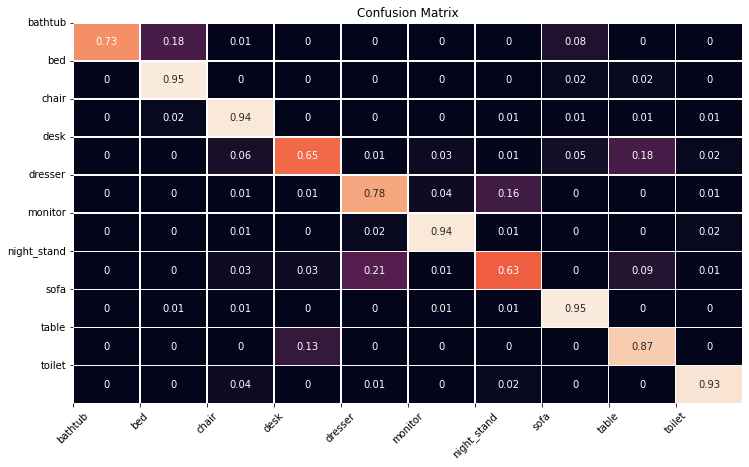

In [8]:
fig=plt.figure(figsize = (12,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)
plt.title("Confusion Matrix")
        

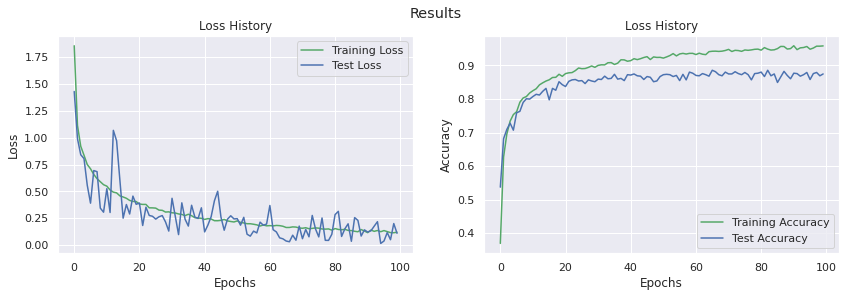

In [9]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

eps = range(0, len(history["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Results')
       
ax[0].plot(eps, smooth(history["train_loss"].cpu()), 'g', label='Training Loss')
ax[0].plot(eps, smooth(history["test_loss"].cpu()), 'b', label='Test Loss')
ax[0].set_title('Loss History')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()
        
ax[1].plot(eps, smooth(history["train_acc"].cpu()), 'g', label='Training Accuracy')
ax[1].plot(eps, smooth(history["test_acc"].cpu()), 'b', label='Test Accuracy')
ax[1].set_title('Loss History')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()